In [21]:
import sys
sys.path.insert(1, '../')
import os 
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pydicom as dcm
import math
from numpy import sqrt, sin, cos, pi, exp, log
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.optimize
import scipy as scipy
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [22]:
[height, width, N] = [224, 224, 224*6]

#...,int(ramp) ax
#:,int(ramp),: sag

In [23]:
# read image sizes then clear the memory 
filePath = "../lib/resource/data/UTE/UTE_ANKLE"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
dirs = np.sort(dirs)
images = np.zeros([height,width,N])

for index,f in enumerate (dirs):
    image = dcm.read_file(f)
    data = apply_voi_lut(image.pixel_array, image)
    images[:,:,index] = data

In [24]:
images.shape

(224, 224, 1344)

In [25]:
images_TE02 = images[:,:,0:224] #  0.2ms
images_TE08 = images[:,:,224:448] # 0.8ms 
images_TE20 = images[:,:,448:672] # 2ms 

In [26]:
def show(ramp):
    _, ax = plt.subplots(1,1, figsize=(5,5))
    plt.imshow(images_TE02[:,int(ramp),::-1].T, cmap="gray")
   
interact(show, ramp = widgets.FloatSlider(value=10,
                                               min=0,
                                               max=224,
                                               step=1))

#...,int(ramp) ax
#:,int(ramp),: sag

interactive(children=(FloatSlider(value=10.0, description='ramp', max=224.0, step=1.0), Output()), _dom_classe…

<function __main__.show(ramp)>

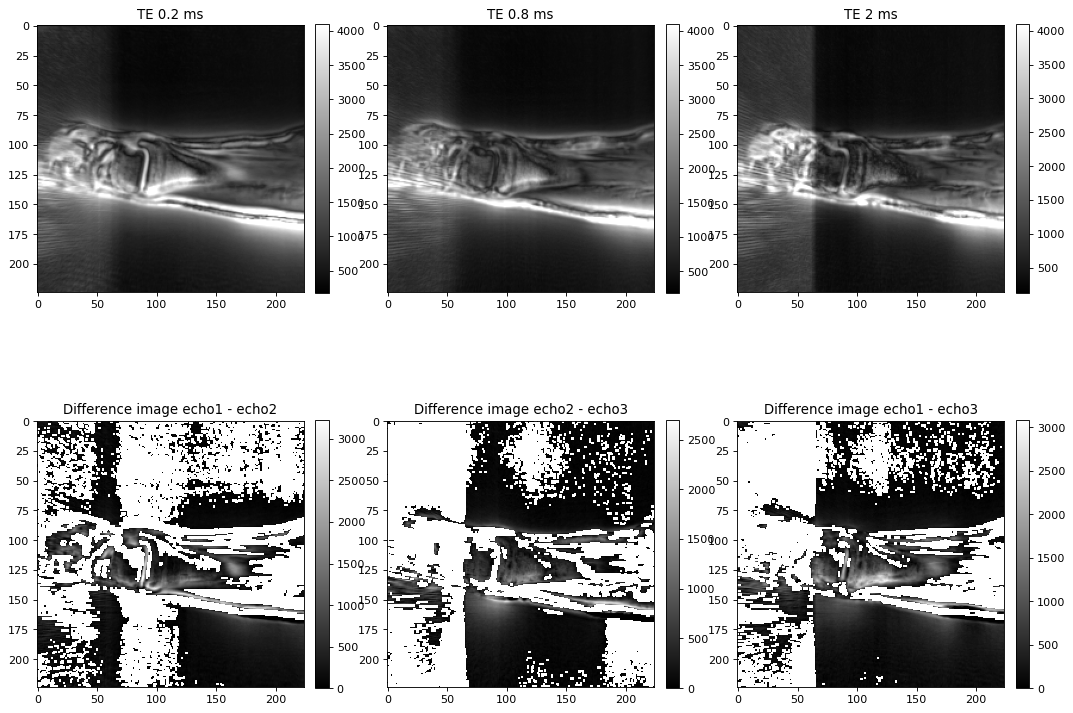

In [6]:
#%matplotlib qt 
%matplotlib inline
slice = 100
plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(231)
tf = plt.imshow(images_TE02[slice,:,:],cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("TE 0.2 ms")
plt.subplot(232)
tf = plt.imshow(images_TE08[slice,:,:],cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("TE 0.8 ms")
plt.subplot(233)
tf = plt.imshow(images_TE20[slice,:,:],cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("TE 2 ms")
plt.subplot(234)
d1 = images_TE02[slice,:,:]- images_TE08[slice,:,:]
d1[d1 < 0 ] = np.nan
tf = plt.imshow(d1,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("Difference image echo1 - echo2")
plt.subplot(235)
d2 = images_TE08[slice,:,:]- images_TE20[slice,:,:]
d2[d2 < 0 ] = np.nan
tf = plt.imshow(d2,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("Difference image echo2 - echo3")
plt.subplot(236)
d3 = images_TE02[slice,:,:]- images_TE20[slice,:,:]
d3[d3 < 0 ] = np.nan
tf = plt.imshow(d3,cmap ="gray")
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("Difference image echo1 - echo3")
plt.show()

In [6]:
def monoExp(TE, A, T2s, B):
    return A * np.exp(-TE/T2s) + B

[156.86304514 129.84311968  98.43390805]
[98.2234745   1.60731866 70.13178259]
1.6073186639286505


/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


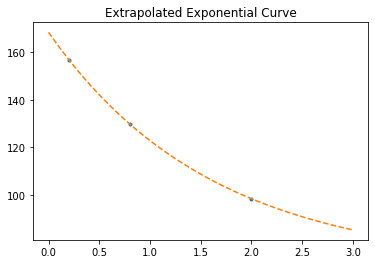

In [7]:
slice = 80
xx = 88
yy = 130
xs = [0.2,0.8,2]
ys = np.array([images_TE02[slice,yy,xx],images_TE08[slice,yy,xx],images_TE20[slice,yy,xx]])
print(ys)
p0 = (200, 20, 100) 
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, bounds=((-np.inf, 0, -np.inf),(np.inf, np.inf, np.inf)))
m, t2, b = params
print(params)
xs2 = np.linspace(0,3,100)
ys2 = monoExp(xs2, m, t2, b)
plt.plot(xs, ys, '.')
plt.plot(xs2, ys2, '--')
plt.title("Extrapolated Exponential Curve")
print(t2)

In [8]:
slice = 80
xs = [0.2,0.8,2]
p0 = (2000, 0.2, 10) 
t2map = np.zeros([height,width])
for y in range(height):
    for x in range(width):
        try:
            ys = np.array([images_TE02[slice,y,x],images_TE08[slice,y,x],images_TE20[slice,y,x]])
            params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
            m, t2, b = params
            t2map[y,x] = t2
        except RuntimeError:
            t2map[y,x] = np.nan

/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/5d/6p36mvb505x5j7b_90jtxdsr0000gn/T/ipykernel_60570/1780042430.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-TE/T2s) + B
/var/folders/5d/6p36mvb505x5j7b_90jtxdsr0000gn/T/ipykernel_60570/1780042430.py:2: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(-TE/T2s) + B


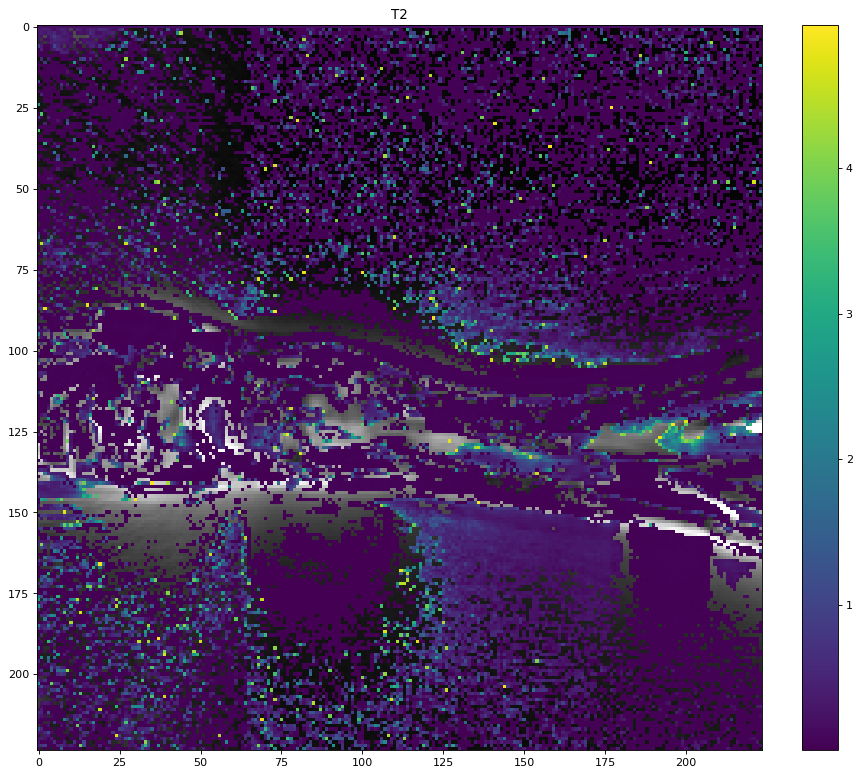

In [9]:
t2map[t2map>=5] = np.nan
t2map[t2map<=0] = np.nan
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(images_TE02[slice,:,:],cmap ="gray")
tf = plt.imshow(t2map)
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("T2")
plt.show()